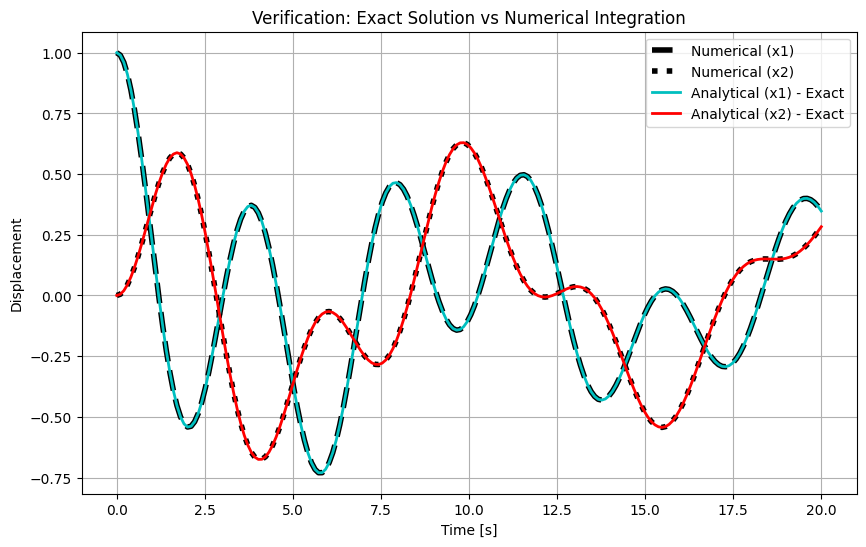

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# --- (A) パラメータ設定 ---
m = 1.0  # m1 = m2
k = 1.0  # k1 = k2
c = 0.05  # 減衰係数

# 行列
M = np.array([[m, 0], [0, m]])
K = np.array([[2*k, -k], [-k, k]])
C = np.array([[2*c, -c], [-c, c]])

# --- (B) 固有値解析 & モード定数 ---
evals, evecs = np.linalg.eigh(np.linalg.inv(M) @ K)
omega_n = np.sqrt(evals)
Phi = evecs

# モード減衰比 h_i の計算
# h_i = (phi^T C phi) / (2 * w * phi^T M phi)
M_gen = np.diag(Phi.T @ M @ Phi)
C_gen = np.diag(Phi.T @ C @ Phi)
h_vec = C_gen / (2 * omega_n * M_gen)

# 減衰固有角振動数 w_d
omega_d = omega_n * np.sqrt(1 - h_vec**2)

# --- (C) 初期条件 ---
x0 = np.array([ 1.0, 0.0]) # 初期変位
v0 = np.array([0.0, 0.0]) # 初期速度

# --- (D) 厳密解の計算 (Analytical) ---
# 1. 初期値をモード座標へ変換: q(0) = Phi^(-1) * x(0)
q0 = np.linalg.inv(Phi) @ x0

def analytical_solution(t):
    x_exact = np.zeros((len(t), 2))

    for i in range(2):
        # 各モードの厳密解: q(t) = q0 * e^(-hwt) * (cos + ...)
        term_decay = np.exp(-h_vec[i] * omega_n[i] * t)
        term_oscill = np.cos(omega_d[i] * t) + \
                      (h_vec[i] / np.sqrt(1 - h_vec[i]**2)) * np.sin(omega_d[i] * t)

        q_i_t = q0[i] * term_decay * term_oscill

        # 物理座標への足し合わせ
        x_exact[:, 0] += Phi[0, i] * q_i_t
        x_exact[:, 1] += Phi[1, i] * q_i_t

    return x_exact

# --- (E) 数値解の計算 (Numerical) ---
def equations(y, t):
    x = y[0:2]; v = y[2:4]
    force = - (C @ v + K @ x)
    a = np.linalg.inv(M) @ force
    return np.concatenate([v, a])

y0 = np.concatenate([x0, v0])
t_span = np.linspace(0, 20, 200)
sol_num = odeint(equations, y0, t_span)

# --- (F) グラフ描画 ---
x_anal = analytical_solution(t_span)

plt.figure(figsize=(10, 6))
# 数値解（黒・点線）
plt.plot(t_span, sol_num[:, 0], 'k--', lw=4, label='Numerical (x1)')
plt.plot(t_span, sol_num[:, 1], 'k:', lw=4, label='Numerical (x2)')
# 厳密解（カラー・実線）
plt.plot(t_span, x_anal[:, 0], 'c-', lw=2, label='Analytical (x1) - Exact')
plt.plot(t_span, x_anal[:, 1], 'r-', lw=2, label='Analytical (x2) - Exact')

plt.title('Verification: Exact Solution vs Numerical Integration')
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.legend()
plt.grid(True)
plt.show()